## Simple models

In [1]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
from scipy import stats

### Running data

Data read with shape (101631, 555) and stored in variable df
Dataset organized by domain stored in variable df_domains.
Domain names: Index(['zh', 'fr', 'en', 'de', 'ru', 'nt', 'ja', 'es'], dtype='object')


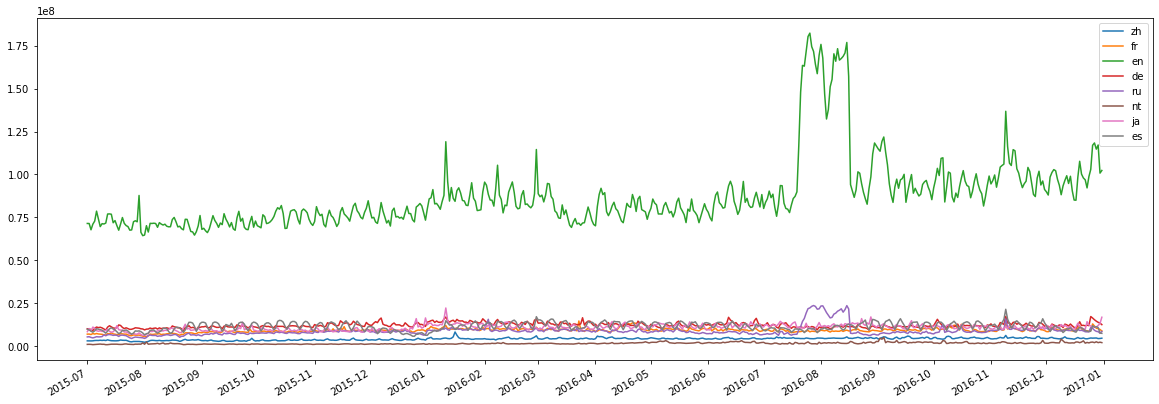

In [2]:
%run data_domains.ipynb

In [3]:
series = df_domains['en'].astype('float64').asfreq('d')
series

2015-07-01     71465103.0
2015-07-02     71434063.0
2015-07-03     67769019.0
2015-07-04     71054893.0
2015-07-05     72825827.0
                 ...     
2016-12-27    118372705.0
2016-12-28    114788377.0
2016-12-29    117190519.0
2016-12-30    100799549.0
2016-12-31    102353122.0
Freq: D, Name: en, Length: 550, dtype: float64

In [4]:
def plot_results(model_fit, series, first_index=None, name_model=""):
    fig, ax = plt.subplots(nrows=2,figsize=(25,10))
    fig.tight_layout(pad=5.0)
    ax[0].set(title=f'Model result [{name_model}]', xlabel='Date', ylabel='Number of accesses')

    series.plot(ax=ax[0], style='o',label='Observed')

    # We start at 2nd index because the first description of an ARIMA model cannot be made without value before so it won't make a lot of sense
    if first_index is None:
        first_index = series.index[1]

    # One step prediction
    predict_os = model_fit.get_prediction(start=first_index)
    predict_os_ci = predict_os.conf_int() # confidence intervals

    # Dynamic forecast since the start
    predict_dy = model_fit.get_prediction(dynamic=first_index)
    predict_dy_ci = predict_dy.conf_int() # confidence intervals


    # Plot predictions
    predict_os.predicted_mean.plot(ax=ax[0],style='r--',label='One-step-ahead forecast')
    ci = predict_os_ci.loc[first_index:]
    ax[0].fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

    predict_dy.predicted_mean.loc[first_index:].plot(ax=ax[0], style='g', label=f'Dynamic forecast {first_index}')
    ci = predict_dy_ci.loc[first_index:]
    ax[0].fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

    # Plot error
    ax[1].set(title='Forecast error', xlabel='Date', ylabel='Error (difference)')

    forecast_error_os =(predict_os.predicted_mean-series)
    forecast_error_os.plot(ax=ax[1],style='r',label='One-step-ahead forecast')

    ci = predict_os_ci.loc[first_index:].copy()
    ci.iloc[:,0] -= series.loc[first_index:]
    ci.iloc[:,1] -= series.loc[first_index:]
    ax[1].fill_between(ci.index,ci.iloc[:,0],ci.iloc[:,1],color='r',alpha=0.1)

    forecast_error_dy =(predict_dy.predicted_mean-series)
    forecast_error_dy.plot(ax=ax[1],style='g',label=f'Dynamic forecast {first_index}')
    ci = predict_dy_ci.loc[first_index:].copy()
    ci.iloc[:,0] -= series.loc[first_index:]
    ci.iloc[:,1] -= series.loc[first_index:]
    ax[1].fill_between(ci.index,ci.iloc[:,0],ci.iloc[:,1],color='g', alpha=0.1)

    ax[0].legend(loc='lower right')    
    ax[1].legend(loc='lower right')
    
    plt.show()

### AR model

The idea of this following models is not to create a real usable model that we can use in the real world. Because of course it won't give us good results. That's why we fit the model with all the time series just to give us an idea on how the model could perform.


Following the *ACF* and *PACF*, we can see there's a corroletation at $lag=1$. AR processes will exhibit exponential decay in ACF and a cut-off in PACF which can lead to a first good simple model.
The final results shows us that by knowing the step before the prediction, we get really good results. But of course if we try to create a dynamic prediction (takes the result of the prediction to make the next prediction, etc..), we easily get awfull results. This series cannot be defined only by an Autoregressive model.

In [5]:
ar_model =sm.tsa.statespace.SARIMAX(series, order=(1,0,0)).fit(disp=False)
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     en   No. Observations:                  550
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -9438.710
Date:                Tue, 14 Dec 2021   AIC                          18881.419
Time:                        16:24:24   BIC                          18890.039
Sample:                    07-01-2015   HQIC                         18884.788
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9971      0.003    395.982      0.000       0.992       1.002
sigma2      4.675e+13    2.6e-18    1.8e+31      0.000    4.68e+13    4.68e+13
===================================================================================
Ljung-Box (L1) (Q):                   4.72   Jarque-Bera (JB):              5888.19
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               5.41   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

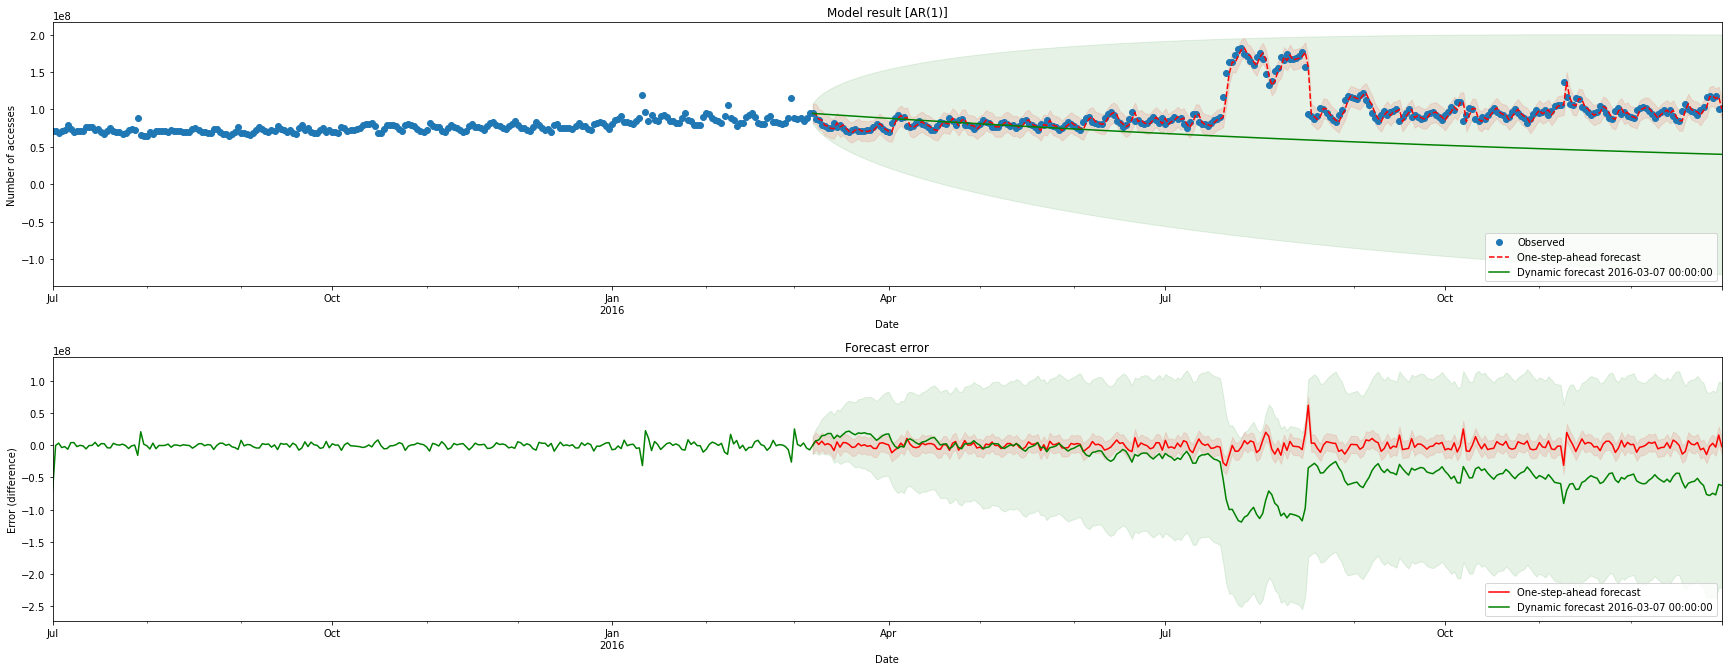

In [6]:
plot_results(ar_model, series, first_index=series.index[-300],name_model="AR(1)")

### ARMA

By setting an `ARMA` model we will also add the idea of moving average so we can try to see if the moving average by noise will help. This doesn't change that much from the result of `AR(1)`, the problem comes from that they are both a stationnary model and our data seems to have some treding to it.

In [7]:
arma_model =sm.tsa.statespace.SARIMAX(series, order=(1,0,1)).fit(disp=False)
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     en   No. Observations:                  550
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -9435.671
Date:                Tue, 14 Dec 2021   AIC                          18877.342
Time:                        16:24:25   BIC                          18890.272
Sample:                    07-01-2015   HQIC                         18882.395
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9972      0.003    359.650      0.000       0.992       1.003
ma.L1          0.1160      0.021      5.453      0.000       0.074       0.158
sigma2      4.644e+13   1.84e-16   2.52e+29      0.000    4.64e+13    4.64e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              4995.04
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               5.05   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.07e+44. Standard errors may be unstable.
"""

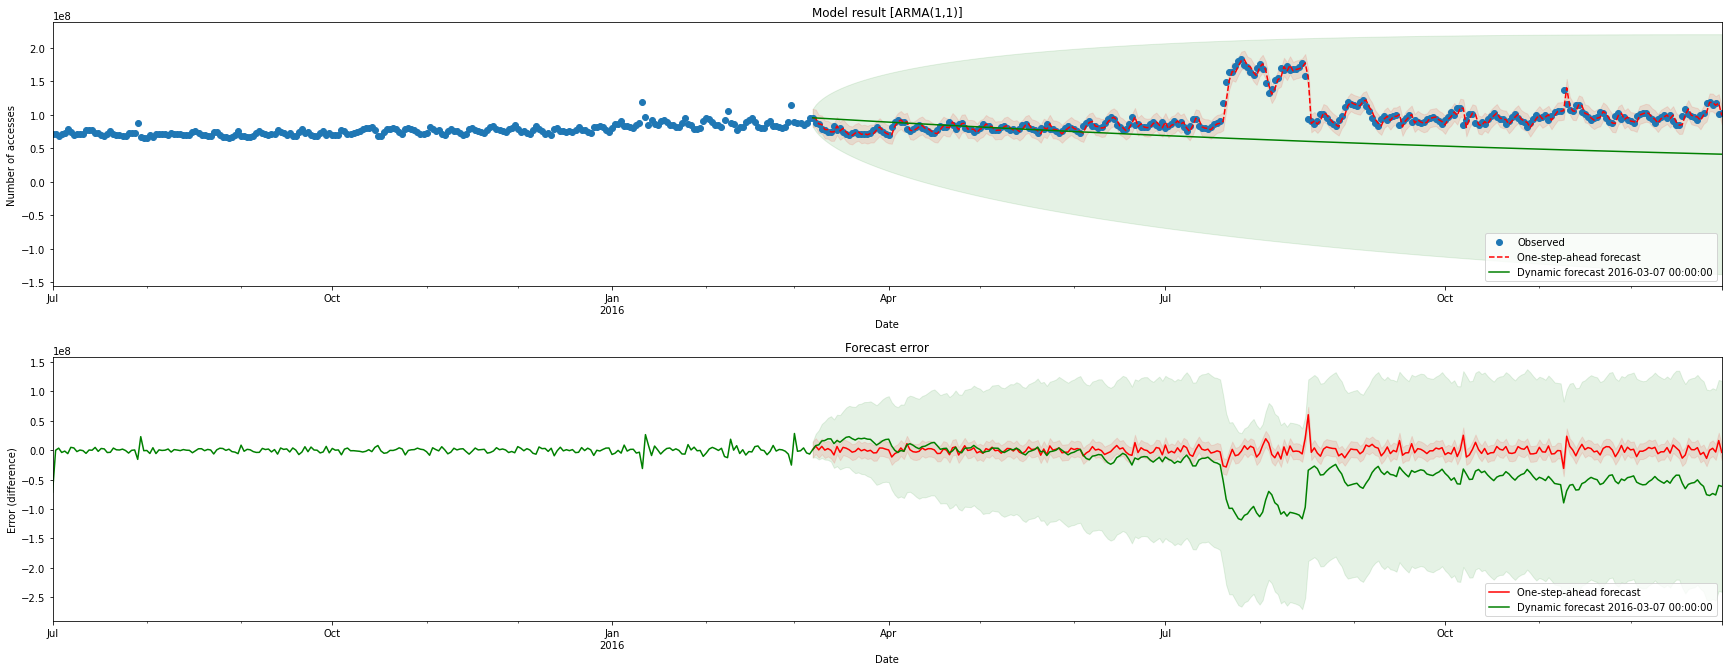

In [8]:
plot_results(arma_model, series, first_index=series.index[-300], name_model="ARMA(1,1)")

### ARIMA

The `PACF` and `ACF` don't really have a big cut-off and never stay at $0$, this mean stationary models won't really work.
With an `ARIMA` model we have finally a model for nonstationnary data. This means we can remove the trend by differencing the *dth* degree of differencing (number of times it was differenced).

We finally get results that make sense, this model can extract the trend of our series. The dynamic forecast is slowly catching the one step forecast.

In [9]:
arima_model =sm.tsa.statespace.SARIMAX(series, order=(1,1,1)).fit(disp=False)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     en   No. Observations:                  550
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9415.906
Date:                Tue, 14 Dec 2021   AIC                          18837.812
Time:                        16:24:26   BIC                          18850.736
Sample:                    07-01-2015   HQIC                         18842.863
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3568      0.355     -1.005      0.315      -1.053       0.339
ma.L1          0.4548      0.353      1.288      0.198      -0.238       1.147
sigma2      4.667e+13   1.68e-14   2.78e+27      0.000    4.67e+13    4.67e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5111.64
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.10   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.48e+42. Standard errors may be unstable.
"""

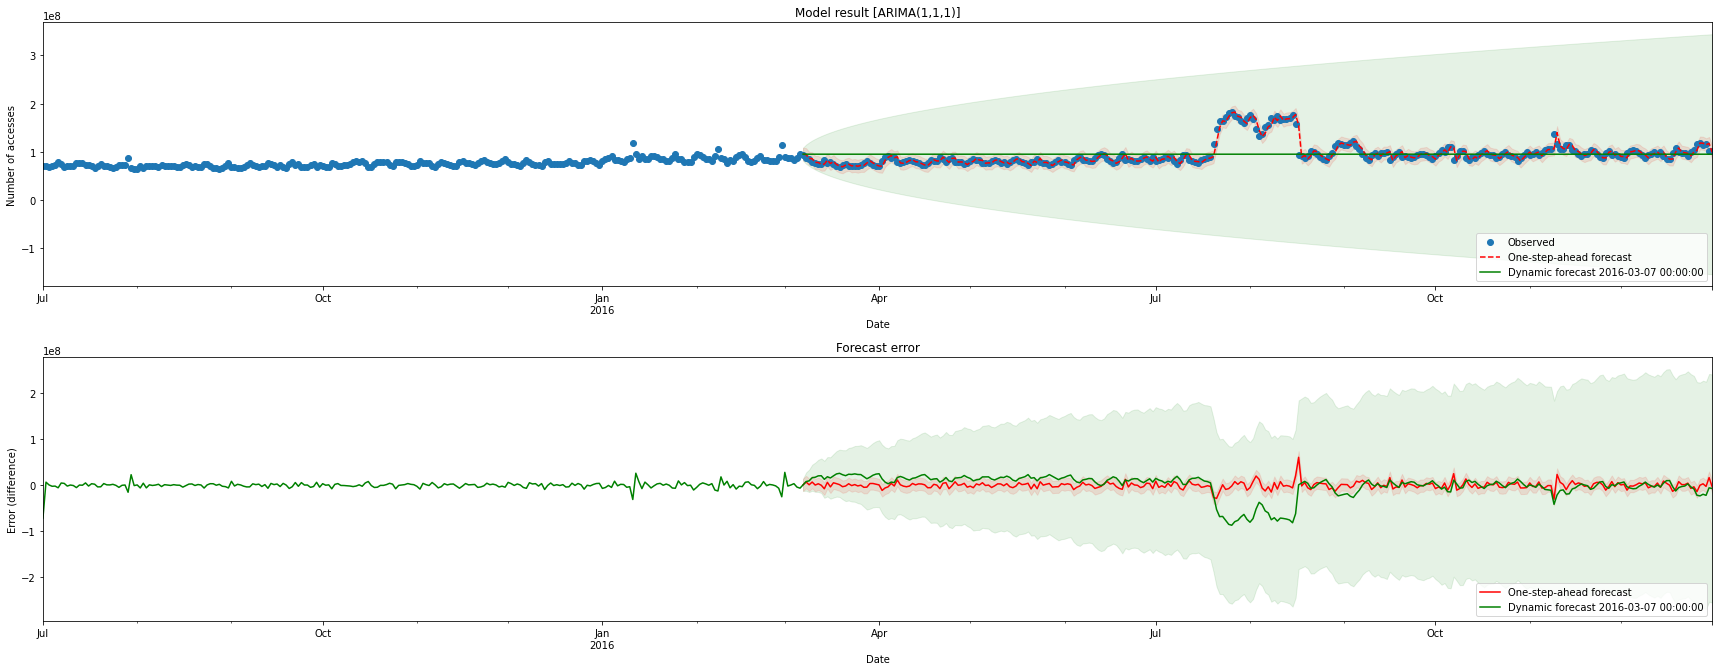

In [10]:
plot_results(arima_model, series,first_index=series.index[-300],name_model="ARIMA(1,1,1)")

### SARIMA

The `SARIMA` model can detect a seasonality by specifying its periodicity. Previously we saw that its periodicity was weekly ($=7$). This doesn't give us good results for the dynamic forecast. Because it doesn'

In [11]:
sarima_model =sm.tsa.statespace.SARIMAX(series, seasonal_order=(1,1,1,7)).fit(disp=False)
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  en   No. Observations:                  550
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -9308.002
Date:                             Tue, 14 Dec 2021   AIC                          18624.004
Time:                                     16:24:27   BIC                          18641.192
Sample:                                 07-01-2015   HQIC                         18630.724
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9351      0.014     65.233      0.000       0.907       0.963
ar.S.L7       -0.0779      0.042     -1.847      0.065      -0.161       0.005
ma.S.L7       -0.8916      0.043    -20.937      0.000      -0.975      -0.808
sigma2      6.436e+13   1.71e-16   3.76e+29      0.000    6.44e+13    6.44e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):              8579.31
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.61e+44. Standard errors may be unstable.
"""

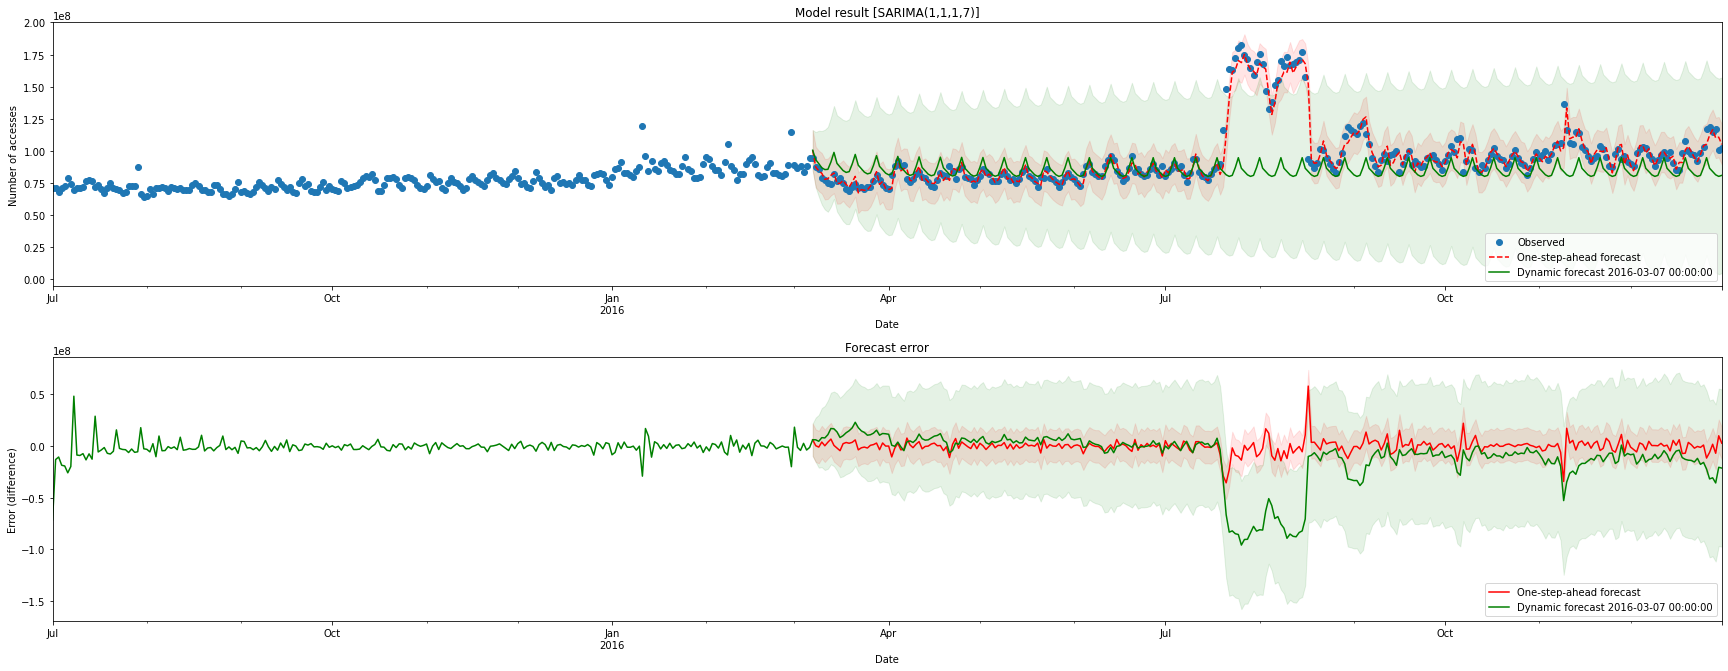

In [12]:
plot_results(sarima_model, series, first_index=series.index[-300],name_model="SARIMA(1,1,1,7)")

### Brute force model

This results shows us the difference between all the models and gives us a first idea on how they work on our data. With the following step, we brute force to try to find the best parameters for the orders ($p,d,q$). The seasonality is clear and stays at $s=7$.

In [13]:
pp = list(range(1,5))
dd = list(range(1,3))
qq = list(range(1,5))
S = 7

The values with the mean square error are really big so we normalize the data. Here we chose a Zero Mean normalization.

In [14]:
series_normalized = (series-series.mean())/series.std()

We simply split the data so it doesn't have any information for the prediction. (the one step prediction will not be perfect now).

In [15]:
def test_model(p,d,q,s,series,train_size,verbose=True):
    N = len(series)
    idx_cut = int(N*train_size)
    series_train = series[:idx_cut]
    series_test = series[idx_cut:]

    model =sm.tsa.statespace.SARIMAX(series, seasonal_order=(p,d,q,s)).fit(disp=False)

    first_index=series_test.index[0]
    # One step prediction
    predict_os = model.get_prediction(start=first_index)
    predict_os_ci = predict_os.conf_int() # confidence intervals

    # Dynamic forecast since the start
    predict_dy = model.get_prediction(dynamic=first_index)
    predict_dy_ci = predict_dy.conf_int() # confidence interval

    # Plot predictions
    if verbose:
        fig, ax = plt.subplots(figsize=(25,5))
        ax.set(title=f'Model result [SARIMA({p},{d},{q},{s})]', xlabel='Date', ylabel='Number of accesses')

        series_train.plot(ax=ax, color='black', style='-',label='Observed')
        series_test.plot(ax=ax, color='dimgray', style='-',label='Observed during forecast')

        predict_os.predicted_mean.plot(ax=ax,style='r--',label='One-step-ahead forecast')
        ci = predict_os_ci.loc[first_index:]
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

        predict_dy.predicted_mean.loc[first_index:].plot(ax=ax, style='g', label=f'Dynamic forecast {first_index.strftime("%d.%m.%Y")}')
        ci = predict_dy_ci.loc[first_index:]
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

        ax.legend()
        plt.show()

    return ((series-predict_dy.predicted_mean)**2).mean()
    

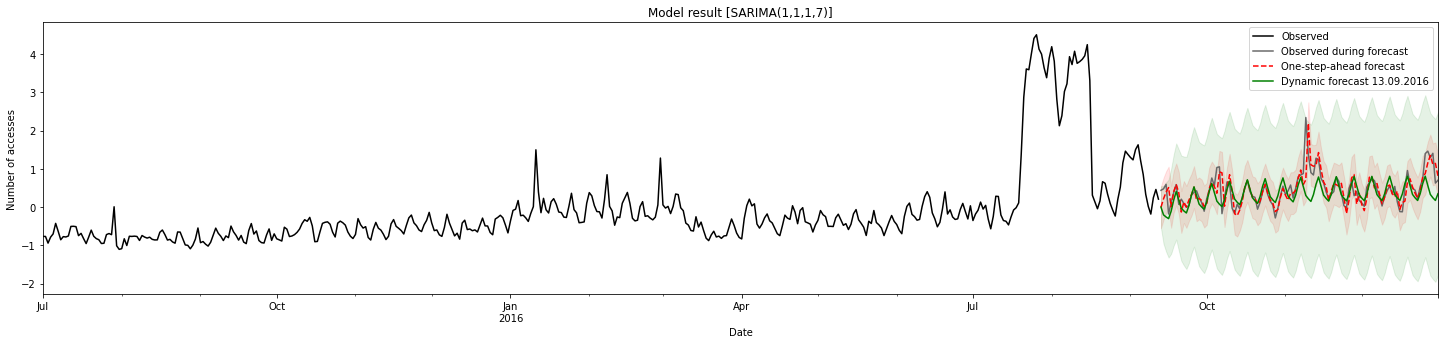

0.09882667208196748

In [51]:
%matplotlib inline
test_model(1,1,1,S,series_normalized,train_size=0.8)

In [17]:
# start all tests with MSE results
results = {}
for p in pp:
    for d in dd:
        for q in qq:
            print(f'Running model: ({p},{d},{q})')
            order = (p,d,q)
            results[order] = test_model(p,d,q,S,series_normalized,train_size=0.85,verbose=False)


Running model: (1,1,1)
Running model: (1,1,2)
Running model: (1,1,3)
Running model: (1,1,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Running model: (1,2,1)
Running model: (1,2,2)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (1,2,3)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (1,2,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Running model: (2,1,1)
Running model: (2,1,2)
Running model: (2,1,3)
Running model: (2,1,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (2,2,1)
Running model: (2,2,2)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (2,2,3)
Running model: (2,2,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (3,1,1)
Running model: (3,1,2)
Running model: (3,1,3)
Running model: (3,1,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (3,2,1)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (3,2,2)
Running model: (3,2,3)
Running model: (3,2,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (4,1,1)
Running model: (4,1,2)
Running model: (4,1,3)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (4,1,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (4,2,1)
Running model: (4,2,2)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (4,2,3)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Running model: (4,2,4)


c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
results_sorted = dict(sorted(results.items(), key=lambda item: item[1]))
print("Results (p,d,q)=MSE")
for order, mse in results_sorted.items():
    print(f'({order[0]},{order[1]},{order[2]})={mse:5f}')

Results (p,d,q)=MSE
(2,1,4)=0.093618
(2,1,3)=0.093836
(2,1,2)=0.094021
(3,1,4)=0.094125
(1,1,3)=0.094236
(4,1,4)=0.094343
(4,1,1)=0.094385
(3,1,2)=0.094764
(3,1,3)=0.094870
(4,1,3)=0.095038
(4,1,2)=0.095080
(1,1,4)=0.095258
(1,1,2)=0.095805
(2,1,1)=0.096405
(1,1,1)=0.096408
(3,1,1)=0.098020
(4,2,3)=0.104479
(4,2,2)=0.105939
(4,2,1)=0.109118
(3,2,2)=0.117885
(3,2,1)=0.119197
(2,2,1)=0.120973
(2,2,3)=0.130393
(1,2,4)=0.131513
(3,2,4)=0.132796
(2,2,2)=0.134337
(1,2,2)=0.141531
(3,2,3)=0.143274
(2,2,4)=0.146544
(4,2,4)=0.147334
(1,2,1)=0.147377
(1,2,3)=0.161002


Create a model with the best results (less MSE).

In [19]:
best_order = (*list(results_sorted.keys())[0], S)
best_order

(2, 1, 4, 7)

In [20]:

sarima_best_model =sm.tsa.statespace.SARIMAX(series_normalized, seasonal_order=best_order).fit(disp=False)
sarima_model.summary()

c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  en   No. Observations:                  550
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -9308.002
Date:                             Tue, 14 Dec 2021   AIC                          18624.004
Time:                                     16:28:09   BIC                          18641.192
Sample:                                 07-01-2015   HQIC                         18630.724
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9351      0.014     65.233      0.000       0.907       0.963
ar.S.L7       -0.0779      0.042     -1.847      0.065      -0.161       0.005
ma.S.L7       -0.8916      0.043    -20.937      0.000      -0.975      -0.808
sigma2      6.436e+13   1.71e-16   3.76e+29      0.000    6.44e+13    6.44e+13
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):              8579.31
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                            -1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.61e+44. Standard errors may be unstable.
"""

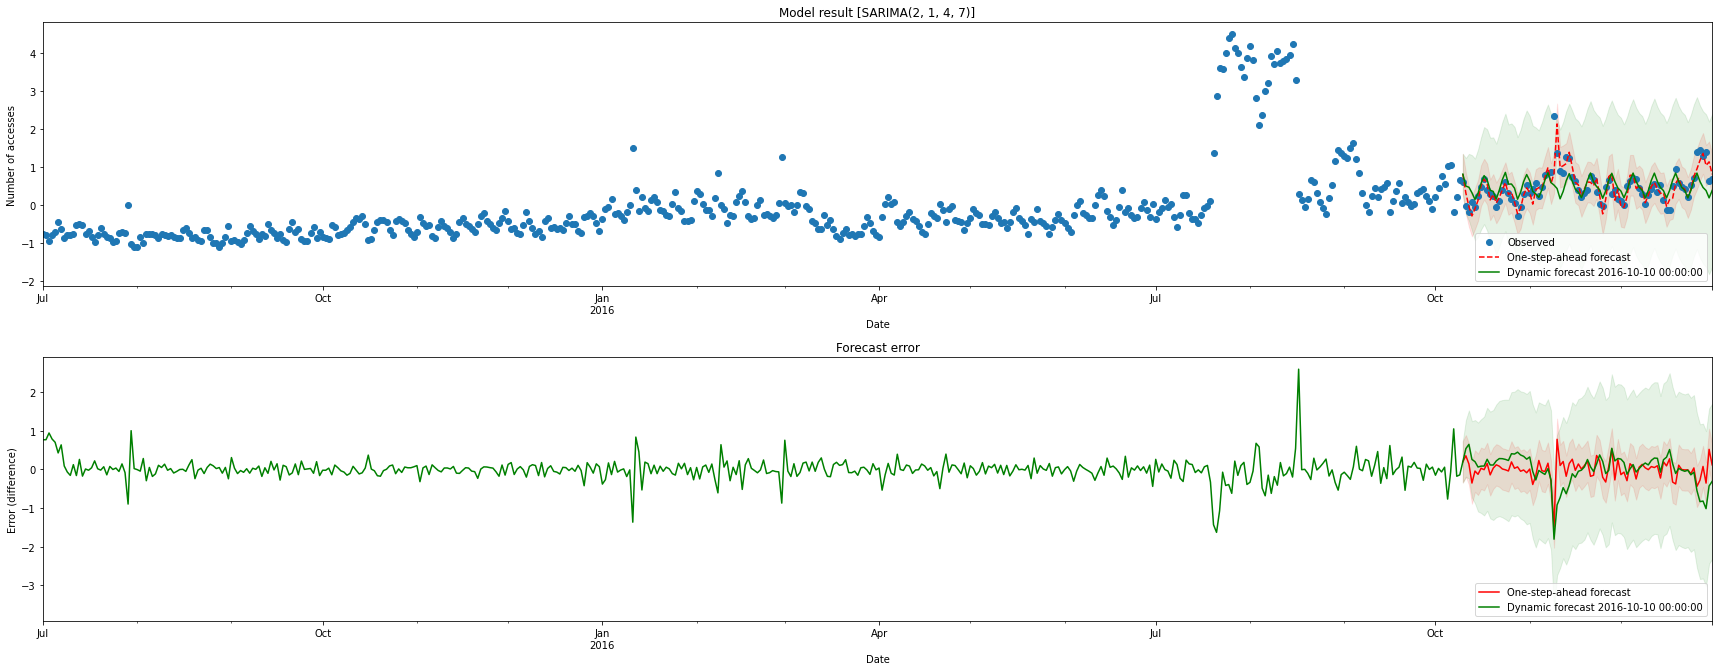

In [21]:
plot_results(sarima_best_model, series_normalized, first_index=series.index[-83],name_model=f"SARIMA{best_order}")

We can now try to optimize or prediction by using a model *ARCH/GARCH* for volatility modelling.
(section helped with [web.vu.lt GARCH](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/03/02_GARCH.html))

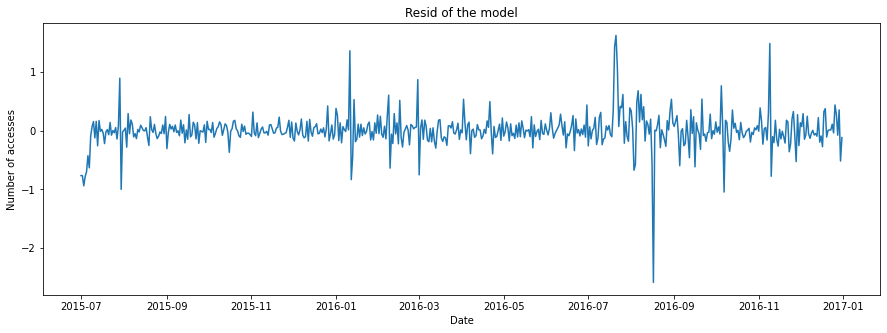

In [22]:
resid = sarima_best_model.resid

fig,ax = plt.subplots(figsize=(15,5))
ax.set(title='Resid of the model',xlabel='Date',ylabel='Number of accesses')
ax.plot(series.index,resid)
plt.show()


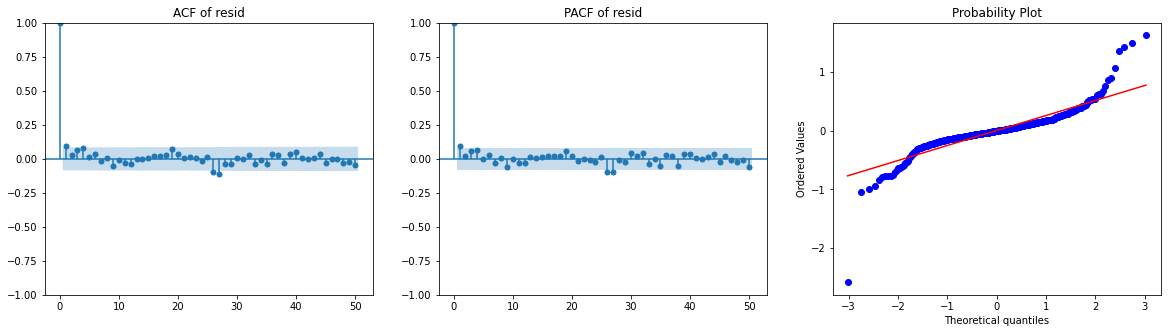

In [61]:
fig, ax = plt.subplots(ncols=3,figsize=(20,5))

acf_plot = plot_acf(resid, lags=50, title='ACF of resid',ax=ax[0])
pacf_plot = plot_pacf(resid, lags=50, title='PACF of resid',method='ywm',ax=ax[1])
stats.probplot(resid, dist="norm", plot=ax[2])

plt.show()

The residual looks like white noise, we can try to square the residuals.

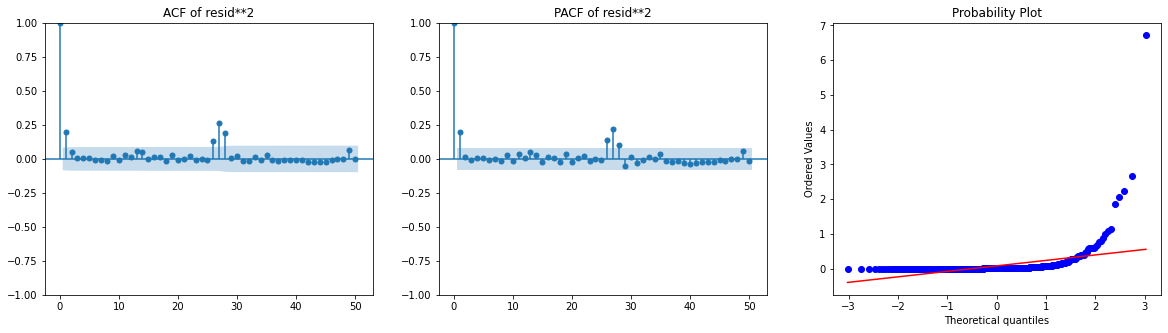

In [62]:
fig, ax = plt.subplots(ncols=3,figsize=(20,5))

acf_plot = plot_acf(resid**2, lags=50, title='ACF of resid**2',ax=ax[0])
pacf_plot = plot_pacf(resid**2, lags=50, title='PACF of resid**2',method='ywm',ax=ax[1])
stats.probplot(resid**2, dist="norm", plot=ax[2])

plt.show()

There's now a correlation shown in both plots at $lag=1$.

In [153]:
# define model
mdl_garch = arch.univariate.ConstantMean(resid)
mdl_garch.volatility = arch.univariate.GARCH(1, 0, 1)
mdl_garch.distribution = arch.univariate.Normal()

In [154]:
# fit model
mdl_garch_fit = mdl_garch.fit(disp='off')
print(mdl_garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                16.8872
Distribution:                  Normal   AIC:                          -25.7744
Method:            Maximum Likelihood   BIC:                          -8.53475
                                        No. Observations:                  550
Date:                Tue, Dec 14 2021   Df Residuals:                      549
Time:                        17:44:44   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.1018e-03  8.232e-03      0.255      0.798 

c:\DEV\AnSeqData\venv\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


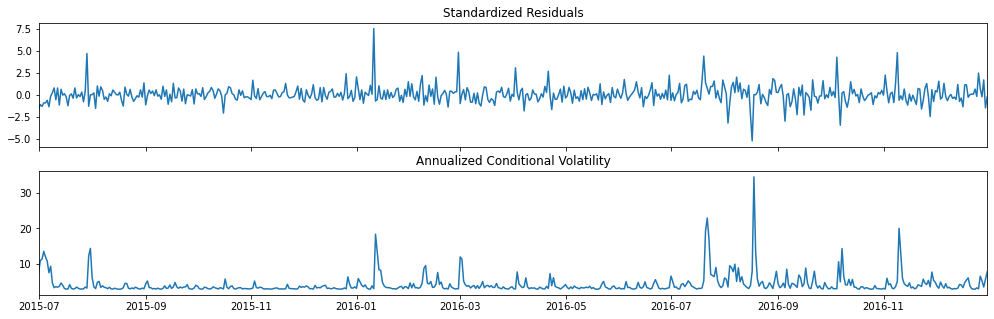

In [155]:
%matplotlib inline
fig = mdl_garch_fit.plot(annualize="D")
fig.set_size_inches(17,5)

We know make sure there's no more correlation in the new residual of the GARCH model.

In [156]:
std_resid = mdl_garch_fit.resid / mdl_garch_fit.conditional_volatility

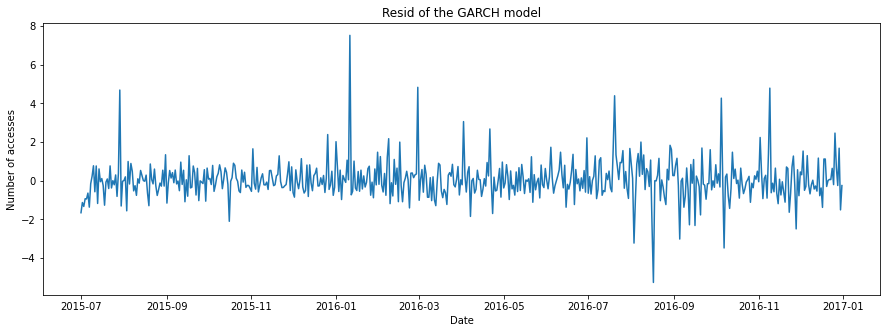

In [157]:
fig,ax = plt.subplots(figsize=(15,5))
ax.set(title='Resid of the GARCH model',xlabel='Date',ylabel='Number of accesses')
ax.plot(std_resid.index,std_resid)
plt.show()

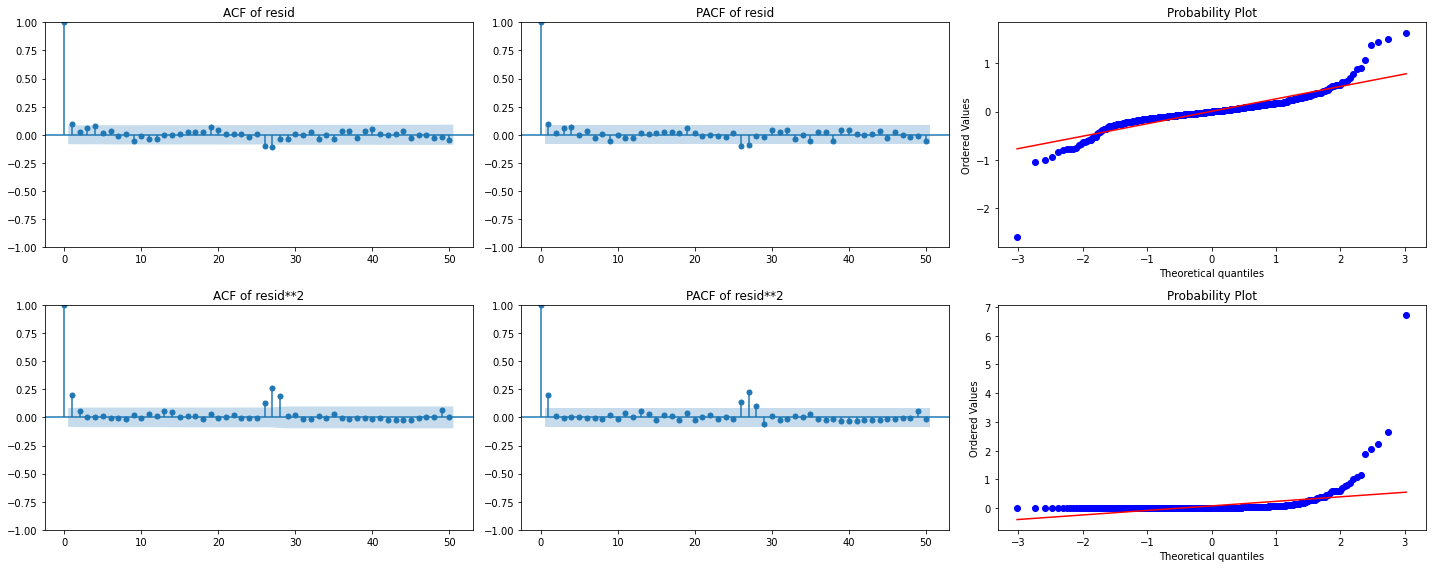

In [158]:
fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(20,8))

acf_plot = plot_acf(resid, lags=50, title='ACF of resid',ax=ax[0][0])
pacf_plot = plot_pacf(resid, lags=50, title='PACF of resid',method='ywm',ax=ax[0][1])
stats.probplot(resid, dist="norm", plot=ax[0][2])
acf_plot = plot_acf(resid**2, lags=50, title='ACF of resid**2',ax=ax[1][0])
pacf_plot = plot_pacf(resid**2, lags=50, title='PACF of resid**2',method='ywm',ax=ax[1][1])
stats.probplot(resid**2, dist="norm", plot=ax[1][2])

fig.tight_layout()
plt.show()

There's still some correlation but for this project we won't try to find any other models that can extract better than *GARCH*.

In [167]:
STEP_AHEAD = 15
mdl_forcs = mdl_garch_fit.forecast(start=series.index[-STEP_AHEAD],horizon = STEP_AHEAD,reindex=False)
mdl_forcs.mean.iloc[0]

plt.figure(figsize=(20,5))

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [137]:
forc_mean = pd.Series(mdl_forcs.mean.iloc[0].dropna().squeeze())
forc_mean.index = series.index[-STEP_AHEAD:]
volatility_mean = pd.Series(mdl_forcs.residual_variance.iloc[0].dropna().squeeze())
volatility_mean.index = forc_mean.index
mean_error = pd.Series(mdl_forcs.variance.iloc[0].dropna().squeeze())
mean_error.index = forc_mean.index


pd.DataFrame([forc_mean, volatility_mean, mean_error], index = ["Forecast", "Volatility", "Forecast Variance"]).T


,Forecast,Volatility,Forecast Variance
2016-12-17,0.000892,0.080206,0.080206
2016-12-18,0.000892,0.097607,0.097607
2016-12-19,0.000892,0.110626,0.110626
2016-12-20,0.000892,0.123193,0.123193
2016-12-21,0.000892,0.134516,0.134516
2016-12-22,0.000892,0.144886,0.144886
2016-12-23,0.000892,0.154346,0.154346
2016-12-24,0.000892,0.162984,0.162984
2016-12-25,0.000892,0.170870,0.170870
2016-12-26,0.000892,0.178069,0.178069


We plot the results of the predicted residual $r_t$ with a $2\sigma$ of confidence.

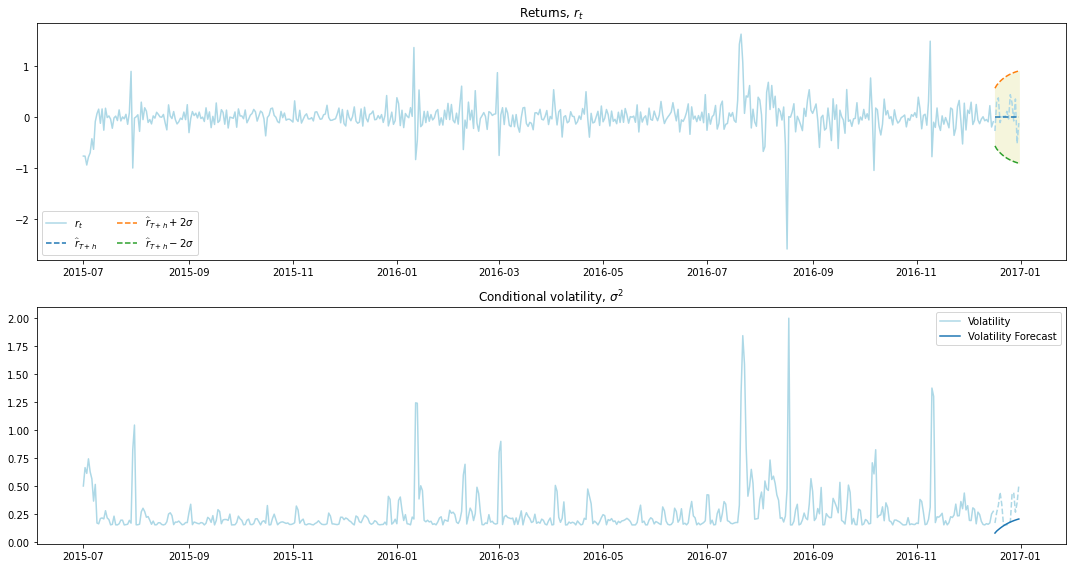

In [152]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(211)
ax1.plot(series.index[:-STEP_AHEAD],resid[:-STEP_AHEAD], '-',color='lightblue',label = "$r_t$")
ax1.plot(series.index[-STEP_AHEAD:],resid[-STEP_AHEAD:], '--',color='lightblue')
ax1.plot(forc_mean, linestyle ="--", label = "$\widehat{r}_{T+h}$")
ax1.plot(forc_mean + 2 * np.sqrt(mean_error), linestyle = "--", label = "$\widehat{r}_{T+h} + 2 \sigma$")
ax1.plot(forc_mean - 2 * np.sqrt(mean_error), linestyle = "--", label = "$\widehat{r}_{T+h} - 2 \sigma$")
ax1.fill_between(forc_mean.index, forc_mean - 2 * np.sqrt(mean_error), forc_mean + 2 * np.sqrt(mean_error), color = "beige")
#
plt.legend(ncol = 2)
plt.title("Returns, $r_t$")
#
#
ax2 = fig.add_subplot(212)
ax2.plot(series.index[:-STEP_AHEAD],mdl_garch_fit.conditional_volatility[:-STEP_AHEAD], '-',color='lightblue',label = "Volatility")
ax2.plot(series.index[-STEP_AHEAD:],mdl_garch_fit.conditional_volatility[-STEP_AHEAD:], '--',color='lightblue')
ax2.plot(volatility_mean, label = "Volatility Forecast")
ax2.legend()
#
plt.title("Conditional volatility, $\sigma^2$")
plt.tight_layout()
plt.show()



Let's now compare both of the prediction with and without the GARCH model on residual.

In [139]:
STEP_AHEAD = 15
real_y = series_normalized[-STEP_AHEAD:]

predict_dy = sarima_best_model.get_prediction(dynamic=series.index[-STEP_AHEAD]).predicted_mean[-STEP_AHEAD:]
mdl_forcs = mdl_garch_fit.forecast(start=series.index[-STEP_AHEAD],horizon = STEP_AHEAD,reindex=False)
volatility_mean = pd.Series(mdl_forcs.residual_variance.iloc[0].dropna().squeeze())
volatility_mean.index = predict_dy.index

In [140]:
mse_without = np.square(predict_dy-real_y).mean()
mse_without

0.3599843456258725

In [141]:
mse_with = np.square((predict_dy+volatility_mean)-real_y).mean()
mse_with

0.2155172183479338

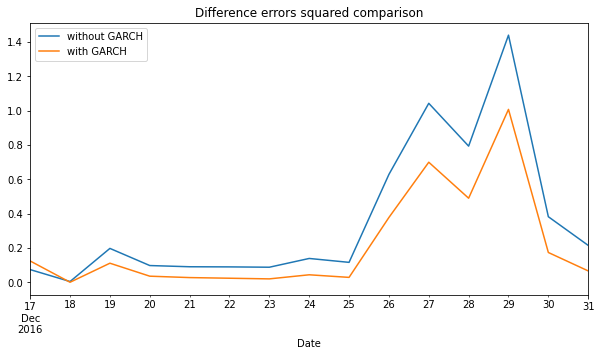

In [142]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set(title='Difference errors squared comparison',xlabel='Date')
np.square(predict_dy-real_y).plot(ax=ax,label='without GARCH')
np.square((predict_dy+volatility_mean)-real_y).plot(ax=ax,label='with GARCH')

ax.legend()

This could of course help the model a bit to have better results but it's a tool that could give even more errors when trying to see too many steps ahead.

Plot the results with interactive mode.

In [38]:
from matplotlib.widgets import Slider,CheckButtons

In [143]:
%matplotlib qt

# Prepare the models
sarima_best_model =sm.tsa.statespace.SARIMAX(series_normalized, seasonal_order=best_order).fit(disp=False)

mdl_garch = arch.univariate.ConstantMean(sarima_best_model.resid)
mdl_garch.volatility = arch.univariate.GARCH(best_order[0], 0, best_order[2])
mdl_garch.distribution = arch.univariate.Normal()

fig, ax = plt.subplots(figsize=(20,8))

# adjust the main plot to make room for the slider
plt.subplots_adjust(left=0.2,bottom=0.20)

#fig.tight_layout(pad=3.0)
ax.set(title=f'Model result [SARIMA{best_order}]', xlabel='Date', ylabel='Number of accesses')
ax.set_ylim([series_normalized.min(), series_normalized.max()*1.5])
series_normalized.plot(ax=ax, color='black', style='-',label='Observed')

valinit_idx = 100
first_index = series.index[-valinit_idx]

predict_os = sarima_best_model.get_prediction(start=first_index)
predict_os_ci = predict_os.conf_int() # confidence intervals
predict_dy = sarima_best_model.get_prediction(dynamic=first_index)
predict_dy_ci = predict_dy.conf_int() # confidence intervals

line_os, = ax.plot(series.index[-valinit_idx:],predict_os.predicted_mean, 'r--',label='One-step-ahead forecast')
ci = predict_os_ci.loc[first_index:]

fill_os =ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1,gid='cios')

#line_dy_full = ax.plot(series.index[:-valinit_idx],predict_dy.predicted_mean[:-valinit_idx],'g-',alpha=0.5)
line_dy, = ax.plot(series.index[-valinit_idx:],predict_dy.predicted_mean[-valinit_idx:], 'g--',label=f'Dynamic forecast {first_index.strftime("%d.%m.%Y")}')
ci = predict_dy_ci.loc[first_index:]
fill_dy = ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1, gid='cidy')

# check box
rax = plt.axes([0.11, 0.4, 0.05, 0.1])
check = CheckButtons(rax, ['GARCH'], [False])

def check_garch(label):
    update(step_slider.val)

check.on_clicked(check_garch)

ax.legend()

# Make a horizontal slider to control the frequency.
axstep = plt.axes([0.1, 0.03, 0.8, 0.03])
step_slider = Slider(
    ax=axstep,
    label="Step",
    valmin=0,
    valmax=len(series),
    valstep=1,
    valinit=valinit_idx,
)

# The function to be called anytime a slider's value changes
def update(val):

    step_ahead = int(val)
    index = series.index[-step_ahead]

    # One step prediction
    predict_os = sarima_best_model.get_prediction(start=index)
    predict_os_ci = predict_os.conf_int() # confidence intervals
    ci_os = predict_os_ci.loc[index:]
    # Dynamic forecast since the start
    predict_dy = sarima_best_model.get_prediction(dynamic=index)
    predict_dy_ci = predict_dy.conf_int() # confidence interval
    ci_dy = predict_dy_ci.loc[index:]

    #with GARCH
    volatility_mean_os = np.zeros(step_ahead)
    volatility_mean_dy = np.zeros(step_ahead)
    if check.get_status()[0]:
        mdl_forcs = mdl_garch_fit.forecast(start=index,horizon=step_ahead,reindex=False)
        volatility_mean_dy = mdl_forcs.residual_variance.iloc[0].dropna().squeeze().values
        volatility_mean_os = mdl_forcs.residual_variance.iloc[:,0].dropna().squeeze().values

    y_dy = predict_dy.predicted_mean[-step_ahead:]+volatility_mean_dy
    line_os.set_data(series.index[-step_ahead:],predict_os.predicted_mean+volatility_mean_os)
    line_dy.set_data(series.index[-step_ahead:],y_dy)
    #line_dy_full.set_data(series.index[:-step_ahead,predict_dy.predicted_mean[:-step_ahead]])
    line_dy.set_label(f'Dynamic forecast {index.strftime("%d.%m.%Y")}')

    for collection in ax.collections:
        if collection.get_gid() == 'cios': # <-- check `gid` instead of `label`
            collection.remove()
        elif collection.get_gid() == 'cidy':
            collection.remove()

    fill_os =ax.fill_between(ci_os.index, ci_os.iloc[:,0], ci_os.iloc[:,1], color='r', alpha=0.1,gid='cios')
    fill_dy =ax.fill_between(ci_dy.index, ci_dy.iloc[:,0], ci_dy.iloc[:,1], color='g', alpha=0.1,gid='cidy')


    ax.legend()

    mse=np.square(y_dy-series_normalized[-step_ahead:]).mean()
    #text= r'$\frac{MSE}{\bar{y}}$'
    ax.set_title(f'Model result [SARIMA{best_order}] | MSE={mse}')

    fig.canvas.draw_idle()

step_slider.on_changed(update)

plt.show()

c:\DEV\AnSeqData\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
